# Introduction to Reinforcement Learning Course - Project
Group Members: Iulia-Elena Teodorescu, Konstantinos Tantoulas, Likhith Bedara Agrahara Venkateshamurthy

## Import libraries

In [50]:
import numpy as np

## Create grid environment

In [ ]:
# Grid dimensions
n_rows = 11
n_cols = 11
actions = ['up', 'down', 'left', 'right']

# Initialize Q-values
q_matrix = np.zeros((n_rows, n_cols, 4))

# Define rewards
reward_matrix = np.full((n_rows, n_cols), -100.)

# Define open areas
open_areas = {1: list(range(1, 10)), 2: [1, 7, 9], 3: list(range(1, 10)),
              4: [3, 7], 5: list(range(1, 10)), 6: [1,3,4,5,9], 7: [1,3,4,5,6,7,8,9],
              8: [1,3, 7,9], 9: [1,2,3,4,5,6,7,9]}

# Set up reward values for different types of locations
DEPOSIT_REWARD = 100
CHARGING_REWARD = -5
OPEN_AREA_REWARD = -1
COLLISION_PENALTY = -50

charging_stations = [(1, 1), (5, 1), (9, 9)] #added

# Assign rewards to cells
def assign_rewards():
    # Assign open area rewards
    for row in range(1, 10):
        for col in open_areas[row]:
            reward_matrix[row, col] = OPEN_AREA_REWARD
    
    # Assign deposit station rewards
    deposit_stations = [(0, 5), (5, 0), (10, 5)]
    for row, col in deposit_stations:
        reward_matrix[row, col] = DEPOSIT_REWARD
    
    # Assign charging station rewards
    charging_stations = [(1, 1), (5, 1), (9, 9)]
    for row, col in charging_stations:
        reward_matrix[row, col] = CHARGING_REWARD

# Set up the reward matrix
assign_rewards()

# Check if state is terminal
def is_terminal_state(row, col):
    return reward_matrix[row, col] != -1.

# Get a random starting position
def random_start(occupied_positions=None):
    if occupied_positions is None:
        occupied_positions = set()
    valid_positions = [(r, c) for r, cols in open_areas.items() for c in cols if (r, c) not in occupied_positions]
    return valid_positions[np.random.randint(len(valid_positions))]

# Assign unique tasks to robots, ensuring tasks are not in occupied positions
def assign_tasks_to_robots(num_robots, occupied_positions):
    tasks = []
    while len(tasks) < num_robots:
        task = random_start(occupied_positions)
        if task not in tasks:
            tasks.append(task)
    return tasks

# Calculate Manhattan distance
def calculate_manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

# Find the closest charging station
def find_closest_charging_station(robot_position, charging_stations):
    min_distance = float('inf')
    closest_station = None
    for station in charging_stations:
        distance = calculate_manhattan_distance(robot_position, station)
        if distance < min_distance:
            min_distance = distance
            closest_station = station
    return closest_station

# Select action using epsilon-greedy strategy
def select_action(row, col, epsilon_value):
    if np.random.random() < epsilon_value:
        return np.random.randint(4)
    return np.argmax(q_matrix[row, col])

# Calculate next position
def calculate_next_position(row, col, action):
    if actions[action] == 'up' and row > 0:
        row -= 1
    elif actions[action] == 'right' and col < n_cols - 1:
        col += 1
    elif actions[action] == 'down' and row < n_rows - 1:
        row += 1
    elif actions[action] == 'left' and col > 0:
        col -= 1
    return row, col

# Check if a position is occupied
def is_position_occupied(pos, occupied_positions):
    return pos in occupied_positions

# Retry logic for collision handling
def retry_action(row, col, epsilon_value, occupied_positions, retries=3):
    for _ in range(retries):
        action = select_action(row, col, epsilon_value)
        next_row, next_col = calculate_next_position(row, col, action)
        if not is_position_occupied((next_row, next_col), occupied_positions):
            return next_row, next_col, action
    return row, col, -1  # Return original position and invalid action if all retries fail

# Move dynamically toward charging station
def move_toward_charger(row, col, target_row, target_col):
    if row < target_row:
        return row + 1, col
    elif row > target_row:
        return row - 1, col
    elif col < target_col:
        return row, col + 1
    elif col > target_col:
        return row, col - 1
    return row, col

def calculate_priority(robot, task_position, max_energy=100):
    distance = calculate_manhattan_distance(robot['position'], task_position)
    priority_score = (robot['energy'] / max_energy) * (1 / (distance + 1))  # Avoid division by zero
    return priority_score

def avoid_congestion(row, col, occupied_positions):
    for action in range(4): 
        next_row, next_col = calculate_next_position(row, col, action)
        if not is_position_occupied((next_row, next_col), occupied_positions):
            return next_row, next_col
    return row, col  # Stay in place if no congestion-free path is found

# Check if the given position is in a high-congestion area
def check_congestion(occupied_positions, position, radius=1, congestion_threshold=1):
    row, col = position
    congestion_count = 0

    for r in range(row - radius, row + radius + 1):
        for c in range(col - radius, col + radius + 1):
            if (r, c) in occupied_positions:
                congestion_count += 1
                if congestion_count >= congestion_threshold:
                    return True  

    return False


## Train agents

In [ ]:
# Training parameters
epsilon = 1.0
gamma = 0.9
alpha = 0.9
max_steps = 100
episodes = 1000
num_robots = 2
initial_energy = 100
energy_cost = 1
low_energy_threshold = 10  # Guide robots to charging stations before they run out of energy
rewards = []

# Initialize tracking variables
task_completions = []
collisions = []

# Training
for episode in range(episodes):

    # Initialize robots and tasks
    occupied_positions = set()
    robots = [{'position': random_start(occupied_positions), 'energy': initial_energy, 'has_package': False} for _ in range(num_robots)]
    for robot in robots:
        occupied_positions.add(robot['position'])
    tasks = assign_tasks_to_robots(num_robots, occupied_positions)

    total_reward = 0
    
    for step in range(max_steps):
        step_occupied_positions = set()

        # Reallocation tasks based on robots' energy and proximity to each task
        task_priority = []
        for i, robot in enumerate(robots):
            if not robot['has_package']:
                # Calculate priority scores for each task
                task_priority.append({
                    'robot': i,
                    'task': tasks[i],
                    'priority': calculate_priority(robot, tasks[i])
                })

        # Sort robots by priority to decide task assignments dynamically
        task_priority.sort(key=lambda x: x['priority'], reverse=True)
        task_assignments = {item['robot']: item['task'] for item in task_priority}
        
        reward = 0
        for i, robot in enumerate(robots):
            row, col = robot['position']

            # Check if the robot needs recharging
            if robot['energy'] <= low_energy_threshold:
                charging_station = find_closest_charging_station((row, col), charging_stations)
                next_row, next_col = move_toward_charger(row, col, *charging_station)

                # Recharge if at charging station
                if (next_row, next_col) == charging_station:
                    robot['energy'] = initial_energy
                reward += reward_matrix[next_row, next_col]  # Charging station reward or open area reward
            else:
                # Select action and calculate next position
                action = select_action(row, col, epsilon)
                next_row, next_col = calculate_next_position(row, col, action)

                collision_occurred = False
                # Handle collisions
                if is_position_occupied((next_row, next_col), step_occupied_positions):
                    # Redirect to avoid congestion
                    if check_congestion(occupied_positions, (next_row, next_col)):
                        next_row, next_col = avoid_congestion(row, col, occupied_positions)
                    else:
                        # Retry action or stay in place if retries fail
                        next_row, next_col, action = retry_action(row, col, epsilon, step_occupied_positions)
                    reward += COLLISION_PENALTY 

            # Task Handling
            if (not robot['has_package'] and (next_row, next_col) == tasks[i]):  # Pick up a package
                robot['has_package'] = True
                reward += reward_matrix[next_row, next_col]
            elif (robot['has_package'] and (next_row, next_col) in deposit_stations):  # Deliver package
                robot['has_package'] = False
                reward += DEPOSIT_REWARD
            else:  # Regular movement reward
                reward += reward_matrix[next_row, next_col]

            # Update energy
            robot['energy'] -= energy_cost

            # Update Q-value
            q_current = q_matrix[row, col, action]
            td_error = reward + gamma * np.max(q_matrix[next_row, next_col]) - q_current
            q_matrix[row, col, action] = q_current + alpha * td_error

            # Update robot's position
            robot['position'] = (next_row, next_col)
            step_occupied_positions.add(robot['position'])

            total_reward += reward

        # Decay epsilon
        epsilon = max(0.01, epsilon * 0.995)

    # Record total reward for the episode
    rewards.append(total_reward)

Task completed by Robot 0 at (4, 3)
Task completed by Robot 0 at (7, 8)
Task completed by Robot 0 at (3, 8)
Task completed by Robot 0 at (4, 3)
Task completed by Robot 0 at (1, 6)
Task completed by Robot 0 at (1, 7)
Task completed by Robot 0 at (3, 6)
Task completed by Robot 0 at (5, 3)
Task completed by Robot 0 at (7, 7)
Task completed by Robot 1 at (3, 4)
Task completed by Robot 1 at (1, 2)
Task completed by Robot 0 at (8, 9)
Task completed by Robot 1 at (1, 4)
Task completed by Robot 1 at (9, 6)
Task completed by Robot 0 at (1, 2)
Task completed by Robot 1 at (3, 1)
Task completed by Robot 0 at (1, 3)
Task completed by Robot 0 at (3, 4)
Task completed by Robot 1 at (3, 7)
Task completed by Robot 0 at (3, 7)
Task completed by Robot 1 at (8, 9)
Task completed by Robot 0 at (1, 6)
Task completed by Robot 0 at (7, 1)
Task completed by Robot 1 at (7, 8)
Task completed by Robot 1 at (1, 6)
Task completed by Robot 0 at (1, 3)
Task completed by Robot 0 at (1, 3)
Task completed by Robot 1 at

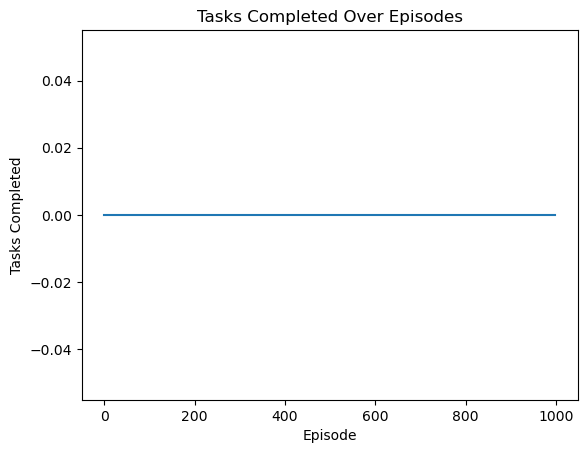

In [53]:
import matplotlib.pyplot as plt

plt.plot(task_completions)
plt.xlabel('Episode')
plt.ylabel('Tasks Completed')
plt.title('Tasks Completed Over Episodes')
plt.show()


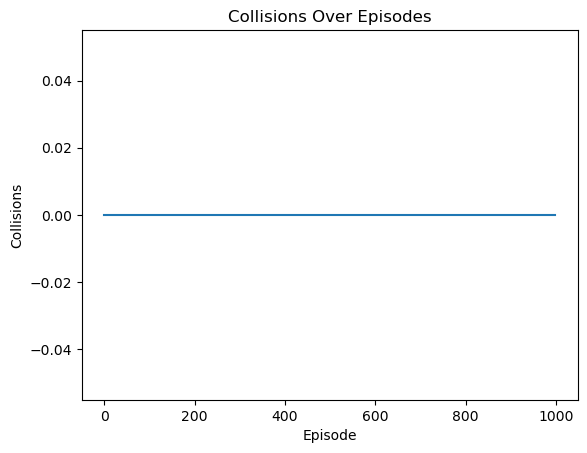

In [54]:
plt.plot(collisions)
plt.xlabel('Episode')
plt.ylabel('Collisions')
plt.title('Collisions Over Episodes')
plt.show()
